<a href="https://colab.research.google.com/github/Fjolnirr/OliveTreeCounting/blob/main/pytorch_maskrcnn_training_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import Libraries

In [2]:
import random
from math import log10, sqrt
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import numpy as np
import torch.utils.data
import cv2
import torchvision.models.segmentation
import torch
import os
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab.patches import cv2_imshow

Settings (batch_size, image_size, num_classes, train_directories, device)

In [5]:
batchSize = 1
imageSize = [600, 600]
numClasses = 2
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')  # train on the GPU or on the CPU, if a GPU is not available
trainDir = "/content/drive/MyDrive/MSc/Thesis/OliveTreeDataset/Train"

imgs = []
for pth in os.listdir(trainDir):
    if(pth.startswith(".")):
      continue
    imgs.append(trainDir + "/" + pth +"/")   
print(imgs)


['/content/drive/MyDrive/MSc/Thesis/OliveTreeDataset/Train/Train1/', '/content/drive/MyDrive/MSc/Thesis/OliveTreeDataset/Train/Train2/']


Data Loader

In [40]:
def loadData(raw_image = 'raw.jpg', masks_folder = 'Masks'):
    batch_Imgs = []
    batch_Data = []  # load images and masks

    for i in range(batchSize):
        idx = random.randint(0, len(imgs) - 1)
        img = cv2.imread(os.path.join(imgs[idx], raw_image))
        img = cv2.resize(img, tuple(imageSize), cv2.INTER_LINEAR)
        maskDir = os.path.join(imgs[idx], masks_folder)
        masks = []
        for mskName in os.listdir(maskDir):
            currMask = (cv2.imread(maskDir + '/' + mskName, 0) > 0).astype(np.uint8)  # Read the instance mask
            currMask = cv2.resize(currMask, tuple(imageSize), cv2.INTER_NEAREST)
            masks.append(currMask)  # get bounding box coordinates for each mask

        num_objs = len(masks)
        if num_objs == 0: return loadData()  # if image have no objects just load another image
        boxes = torch.zeros([num_objs, 4], dtype=torch.float32) # empty no_of_mask_object x 4 array(tensor) to store box coordinates of each obj later on..

        for i in range(num_objs):
            '''Store each instance masks bounding box coordinates to boxes array(tensor)'''
            x, y, w, h = cv2.boundingRect(masks[i])
            boxes[i] = torch.tensor([x, y, x + w, y + h]) 

        masks = torch.as_tensor(masks, dtype=torch.uint8) # Transform masks array into a tensor (which is holding all instance masks)
        img = torch.as_tensor(img, dtype=torch.float32)   # Transform image array into a tensor
        
        #Store boxes, labels, masks data into data dictionary
        data = {} # create empty data dictionary
        data["boxes"] = boxes
        data["labels"] = torch.ones((num_objs,), dtype=torch.int64)  # there is only one class
        data["masks"] = masks
        batch_Imgs.append(img)   # load images
        batch_Data.append(data)  # load masks(with boxes, labels)

    batch_Imgs = torch.stack([torch.as_tensor(tensor_im) for tensor_im in batch_Imgs], 0) # Stack all image in a tensor 
    batch_Imgs = batch_Imgs.swapaxes(1, 3).swapaxes(2, 3)
    return batch_Imgs, batch_Data


In [39]:
a = np.array([[[2,3,6]], [[1,4,7]]])
b = np.array([[[1,4,7]], [[2,3,6]]])
d = np.array([[[0,5,8]], [[2,3,6]]])
a = torch.as_tensor(a)
b = torch.as_tensor(b)
d = torch.as_tensor(d)
c = torch.stack([a,b,d],0)
print(c)
c.swapaxes(1,3).swapaxes(2,3)

tensor([[[[2, 3, 6]],

         [[1, 4, 7]]],


        [[[1, 4, 7]],

         [[2, 3, 6]]],


        [[[0, 5, 8]],

         [[2, 3, 6]]]])


tensor([[[[2],
          [1]],

         [[3],
          [4]],

         [[6],
          [7]]],


        [[[1],
          [2]],

         [[4],
          [3]],

         [[7],
          [6]]],


        [[[0],
          [2]],

         [[5],
          [3]],

         [[8],
          [6]]]])

Loading the Model

In [ ]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)  # load an instance segmentation model pre-trained on COCO
in_features = model.roi_heads.box_predictor.cls_score.in_features  # get number of input features for the classifier
model.roi_heads.box_predictor = FastRCNNPredictor(in_features,
                                                  num_classes=numClasses)  # replace the pre-trained head with a new one 
model.to(device)  # move model to the right device

optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-5)
model.train()

Start Training

In [ ]:
weightDir = "/content/drive/MyDrive/MSc/Thesis/Weights/iter"
iteration = 1000
for i in range(iteration+1):
   images, targets = loadData()
   images = list(image.to(device) for image in images) # Extract all images and upload on device(here : cuda)
   targets=[{k: v.to(device) for k,v in t.items()} for t in targets] # # Extract all data and upload on device(here : cuda)
   
   optimizer.zero_grad() 
   loss_dict = model(images, targets) #input the images and targets list to model
   losses = sum(loss for loss in loss_dict.values())
   
   losses.backward()
   optimizer.step()
   
   print(i,'loss:', losses.item())
   if i%100==0:
           torch.save(model.state_dict(), weightDir+str(i)+".torch")
           print("Save model to:", weightDir+str(i)+".torch")

In [ ]:
#@title Prediction_mask kodu
def prediction_mask(weight_path, im="/content/drive/MyDrive/MSc/Thesis/OliveTreeDataset/Train/Train1/Image.jpg"):
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')  
  model=torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True) 
  in_features = model.roi_heads.box_predictor.cls_score.in_features 
  model.roi_heads.box_predictor=FastRCNNPredictor(in_features,num_classes=2)
  model.load_state_dict(torch.load(weight_path))
  model.to(device)# move model to the right devic
  model.eval()

  images = cv2.imread(im)
  images = cv2.resize(images, (600,600), cv2.INTER_LINEAR)
  images = torch.as_tensor(images, dtype=torch.float32).unsqueeze(0)
  images=images.swapaxes(1, 3).swapaxes(2, 3)
  images = list(image.to(device) for image in images)

  with torch.no_grad():
    pred = model(images)
    pred_mask = pred[0]['masks'][0].cpu().data.numpy()
    bbox = pred[0]['boxes'][0].cpu().data.numpy()
    bbox = [int(x) for x in bbox]

  return pred_mask[0], bbox

In [ ]:
#@title PSNR kodu
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

In [ ]:
#@title evaluate_model kodu
def evaluate_model(truth, pred):
  MSE = np.square(np.subtract(truth,pred)).mean()
  return MSE

In [ ]:
print(loss_dict)

{'loss_classifier': tensor(0.1427, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.9501, device='cuda:0', grad_fn=<DivBackward0>), 'loss_mask': tensor(0.3002, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_objectness': tensor(0.8202, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.8555, device='cuda:0', grad_fn=<DivBackward0>)}


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


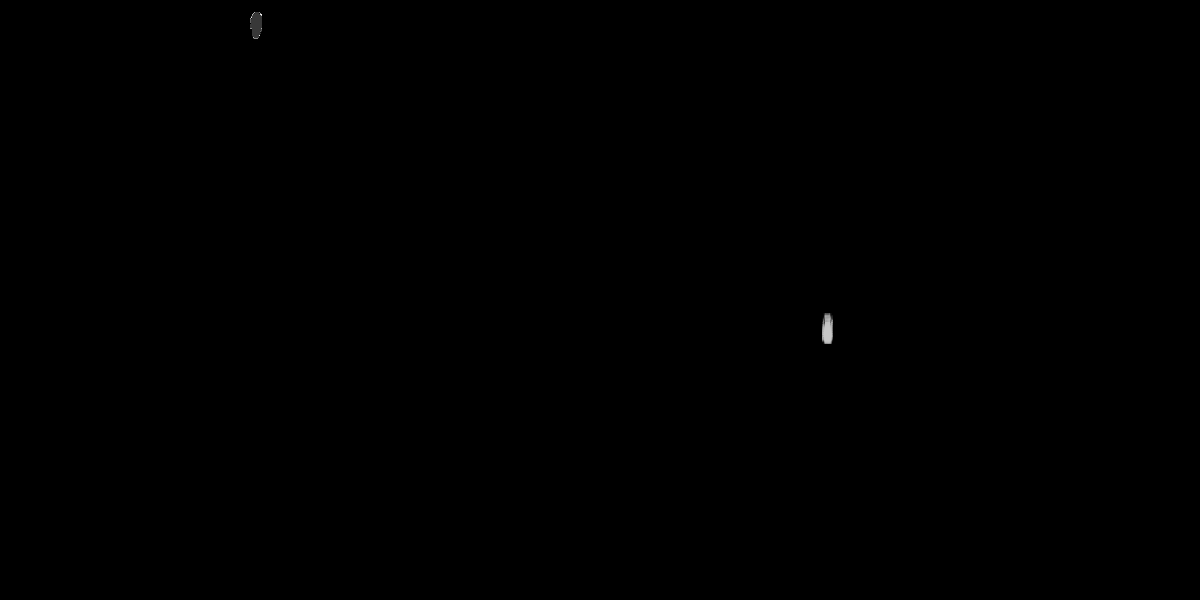

[223, 314, 232, 343]


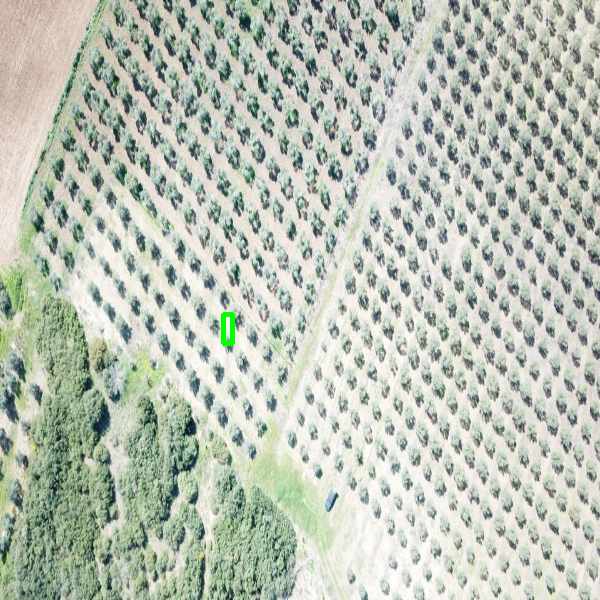

In [ ]:
pred_mask, bbox = prediction_mask("/content/drive/MyDrive/MSc/Thesis/Weights/iter500.torch", "/content/drive/MyDrive/MSc/Thesis/OliveTreeDataset/Train/Train1/Image.jpg")
truth = cv2.imread("/content/drive/MyDrive/MSc/Thesis/OliveTreeDataset/Train/Train1/Masks/mask0.png", 0)
truth = cv2.resize(truth, (600,600))
cv2_imshow(np.hstack([truth*200,pred_mask*200]))

print(bbox)

img = cv2.imread("/content/drive/MyDrive/MSc/Thesis/OliveTreeDataset/Train/Train1/Image.jpg")
img = cv2.resize(img, (600,600))
cv2.rectangle(img,(bbox[0],bbox[1]), (bbox[2], bbox[3]),(0,255,0),3)
cv2_imshow(img)

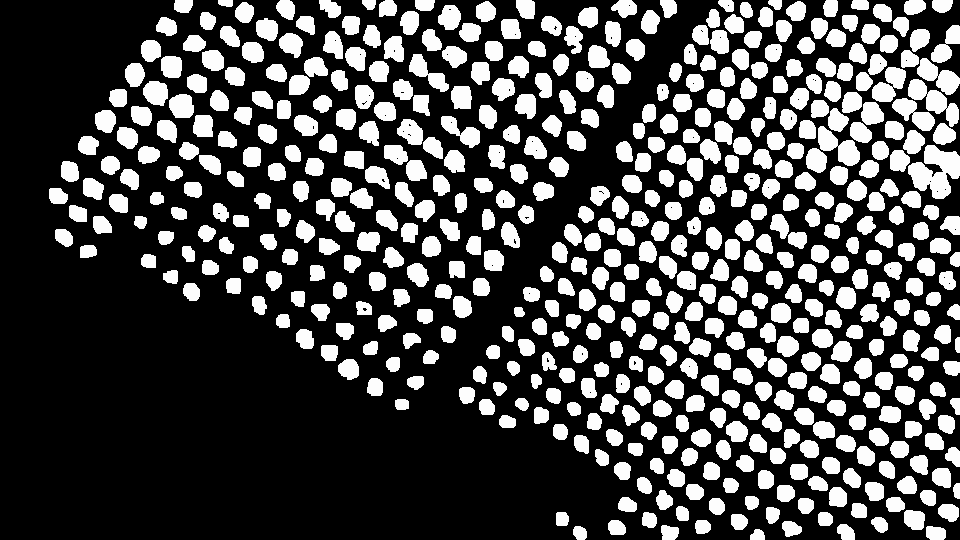

[[[575 526]]

 [[574 527]]

 [[574 528]]

 [[573 529]]

 [[573 534]]

 [[576 537]]

 [[576 538]]

 [[577 539]]

 [[584 539]]

 [[586 537]]

 [[586 531]]

 [[585 530]]

 [[585 529]]

 [[584 528]]

 [[583 528]]

 [[582 527]]

 [[581 527]]

 [[580 526]]]


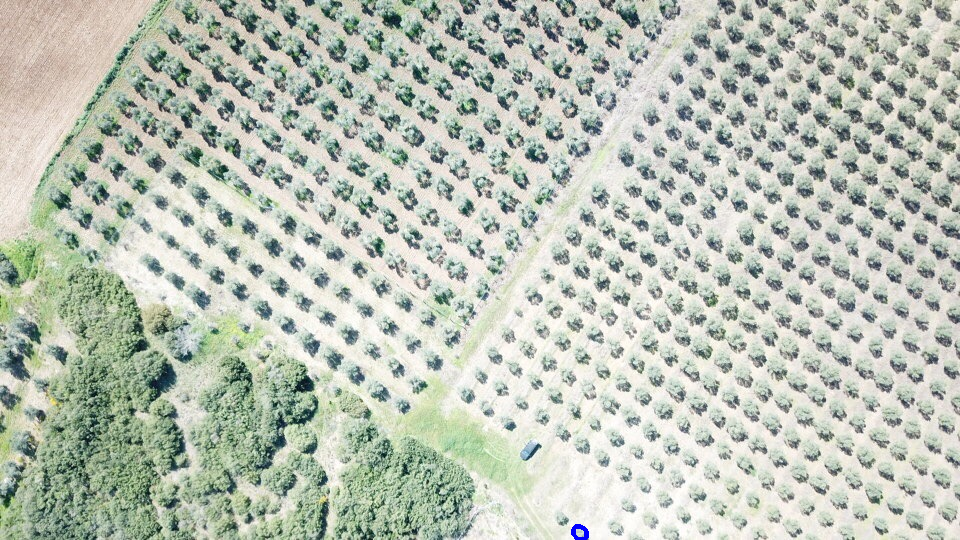

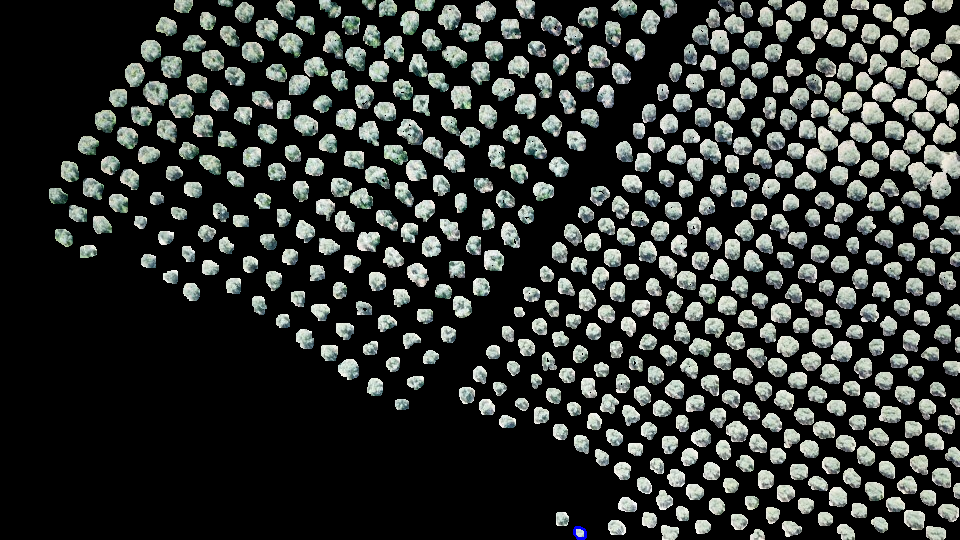

In [ ]:
im = cv2.imread("/content/drive/MyDrive/MSc/Thesis/OliveTreeDataset/Train/Train1/Image.jpg")
#im = cv2.resize(im, (600,600))
gry = cv2.imread("/content/drive/MyDrive/MSc/Thesis/OliveTreeDataset/Train/Train1/Masks/im1_mask.png",0)
#ret,thresh1 = cv2.threshold(gry,1,1,cv2.THRESH_BINARY)
cv2_imshow(gry*255)
ret, thresh = cv2.threshold(gry,1,1,cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnt = contours[2]
print(cnt)
cv2.drawContours(im, [cnt], 0, (255,0,0), 3)
cv2_imshow(im)

res = cv2.bitwise_and(im,im, mask = thresh)
cv2_imshow(res)
#####cv2.imwrite("/content/drive/MyDrive/ColabWorkspace/UAVdataset/Train/Train1/Masks/mask3.png", thresh1)


In [ ]:
cd Train1

/content/drive/MyDrive/MSc/Thesis/OliveTreeDataset/Train/Train1


TEST SECTION

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')  
model=torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True) 
in_features = model.roi_heads.box_predictor.cls_score.in_features 
model.roi_heads.box_predictor=FastRCNNPredictor(in_features,num_classes=2)
model.load_state_dict(torch.load("/content/drive/MyDrive/MSc/Thesis/Weights/iter500.torch"))
model.to(device)# move model to the right devic
model.eval()

In [ ]:
images = cv2.imread("/content/drive/MyDrive/MSc/Thesis/OliveTreeDataset/Test/im (7).jpg")
images = cv2.resize(images, (600,600), cv2.INTER_LINEAR)
images = torch.as_tensor(images, dtype=torch.float32).unsqueeze(0)
images=images.swapaxes(1, 3).swapaxes(2, 3)
images = list(image.to(device) for image in images)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
with torch.no_grad():
    pred = model(images)
    print(pred[0]['masks'][0])
    #rint(len(pred[0]['labels']))

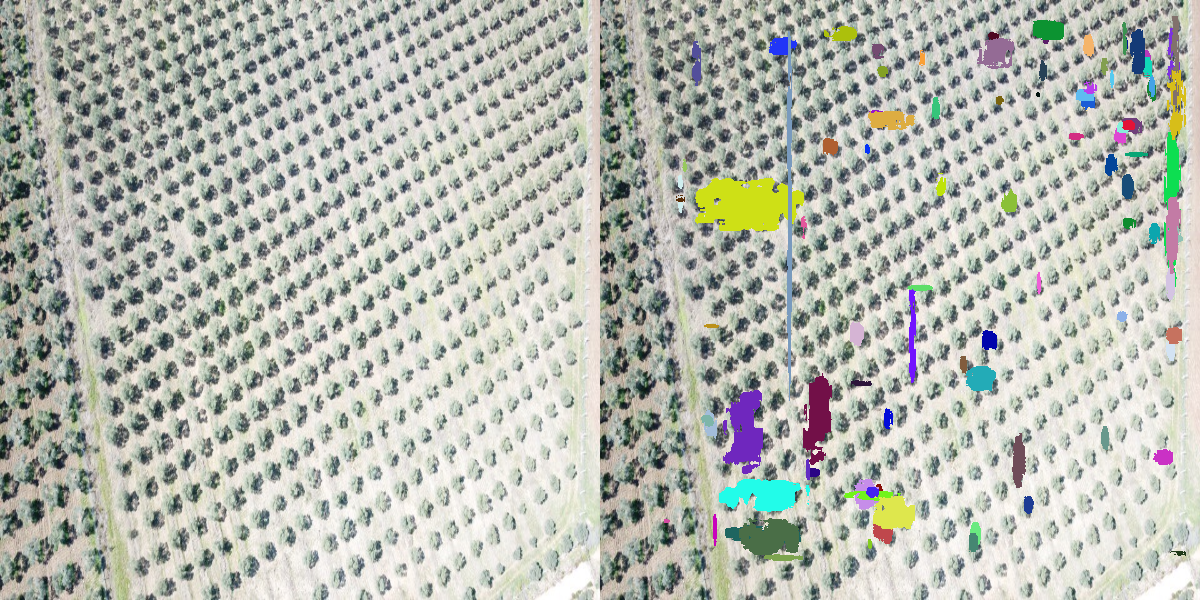

-1

In [ ]:
from google.colab.patches import cv2_imshow
im= images[0].swapaxes(0, 2).swapaxes(0, 1).detach().cpu().numpy().astype(np.uint8)
im2 = im.copy()
for i in range(len(pred[0]['masks'])):
    msk=pred[0]['masks'][i,0].detach().cpu().numpy()
    scr=pred[0]['scores'][i].detach().cpu().numpy()
    if scr>0.0005 :
        im2[:,:,0][msk>0.5] = random.randint(0,255)
        im2[:, :, 1][msk > 0.5] = random.randint(0,255)
        im2[:, :, 2][msk > 0.5] = random.randint(0, 255)
#cv2_imshow(str(scr), np.hstack([im,im2]))
cv2_imshow(np.hstack([im,im2]))


cv2.waitKey()

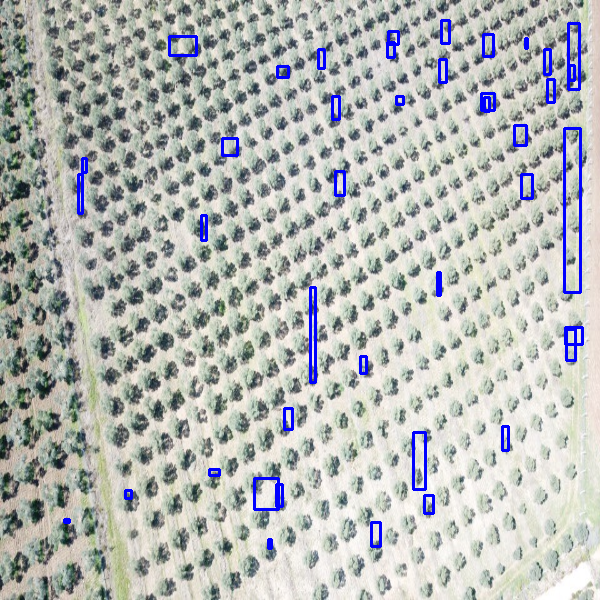

In [ ]:
im= images[0].swapaxes(0, 2).swapaxes(0, 1).detach().cpu().numpy().astype(np.uint8)
im2 = im.copy()
for i in range(len(pred[0]['masks'])):
  msk=pred[0]['masks'][i,0].detach().cpu().numpy()
  scr=pred[0]['scores'][i].detach().cpu().numpy()

  bbox = pred[0]['boxes'][i].detach().cpu().data.numpy()
  bbox = [int(x) for x in bbox]
  if scr >= 0.25:
    cv2.rectangle(im2,(bbox[0],bbox[1]), (bbox[2], bbox[3]),(255,0,0),2)

cv2_imshow(im2)